In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [4]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""

full_df = bq.Client().query(query).to_dataframe()
full_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,286229633,10.02,91.692029,42.868674,15.089279,NaN,None,NL,None,1915.0,16,0.791828,13.853425,944.0,South Holland
1,274111968,8.58,51.959050,38.097513,15.188347,NaN,None,NL,None,1940.0,12,0.670716,14.189965,1143.0,South Holland
2,286582143,7.09,49.708593,36.167509,14.294876,NaN,None,NL,None,1932.0,7,0.691038,13.621055,734.0,South Holland
3,276806062,13.25,59.595171,33.119488,12.983664,NaN,None,NL,None,1912.0,5,0.826279,11.920126,650.0,South Holland
4,277091084,14.32,72.253336,38.021220,15.182823,NaN,None,NL,None,1911.0,6,0.792516,13.041020,756.0,South Holland


In [5]:
full_df.set_index('osm_way_id', inplace=True)

In [6]:
full_df.shape

(1638666, 14)

In [7]:
full_df["city"] = full_df["city"].astype("category")
full_df["state_name"] = full_df["state_name"].astype("category")
full_df["country"] = full_df["country"].astype("category")
full_df["postcode"] = full_df["postcode"].astype("category")
# df["year"] = df["year"].astype(float).astype("Int64")
# df["count_vertices"] = df["count_vertices"].astype(float).astype("Int64")
# df["count_neighbor"] = df["count_neighbor"].astype(float).astype("Int64")
# df["building_levels"] = df["building_levels"].astype(float).astype("Int64")
full_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [8]:
full_df.isna().sum()

bldg_height              0
area                     0
perimeter                0
length                   0
building_levels    1615564
city               1637782
country                  0
postcode           1637821
year                   132
count_vertices           0
compactness              0
complexity               0
count_neighbor         234
state_name               0
dtype: int64

In [9]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# cat_cols = ["city", "postcode"]
cat_cols = [col for col in full_df.columns if col not in (num_cols + label_col)]

In [10]:
corr_df = full_df[num_cols+label_col]
corr_df.head()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor,bldg_height
osm_way_id,,,,,,,,,,
286229633,91.692029,42.868674,15.089279,NaN,1915.0,16,0.791828,13.853425,944.0,10.02
274111968,51.959050,38.097513,15.188347,NaN,1940.0,12,0.670716,14.189965,1143.0,8.58
286582143,49.708593,36.167509,14.294876,NaN,1932.0,7,0.691038,13.621055,734.0,7.09
276806062,59.595171,33.119488,12.983664,NaN,1912.0,5,0.826279,11.920126,650.0,13.25
277091084,72.253336,38.021220,15.182823,NaN,1911.0,6,0.792516,13.041020,756.0,14.32


In [11]:
corr_df.isna().sum()

area                     0
perimeter                0
length                   0
building_levels    1615564
year                   132
count_vertices           0
compactness              0
complexity               0
count_neighbor         234
bldg_height              0
dtype: int64

In [12]:
corr_df['year'] = corr_df['year'].fillna(corr_df['year'].mean())
corr_df['building_levels'] = corr_df['building_levels'].fillna(1)
corr_df['count_neighbor'] = corr_df['count_neighbor'].fillna(0)

In [13]:
corr_df.isna().sum()

area               0
perimeter          0
length             0
building_levels    0
year               0
count_vertices     0
compactness        0
complexity         0
count_neighbor     0
bldg_height        0
dtype: int64

In [14]:
corr_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor,bldg_height
count,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06
mean,1.284413e+02,3.442989e+01,1.248890e+01,1.007538e+00,1.970038e+03,7.308884e+00,8.203220e-01,1.150416e+01,6.270549e+02,6.207659e+00
std,1.201438e+03,4.307075e+01,1.500313e+01,2.078337e-01,3.692439e+01,5.192885e+00,7.008799e-02,5.160273e+00,3.078407e+02,3.795883e+00
min,2.650812e-04,8.183244e-02,3.404680e-02,-4.000000e+00,1.131000e+03,4.000000e+00,2.828082e-02,6.413288e-01,0.000000e+00,-1.020000e+00
25%,1.107290e+01,1.383930e+01,5.054998e+00,1.000000e+00,1.957000e+03,5.000000e+00,7.915906e-01,7.573893e+00,4.300000e+02,2.660000e+00
50%,5.009999e+01,2.977105e+01,1.085595e+01,1.000000e+00,1.976000e+03,5.000000e+00,8.439439e-01,1.113455e+01,6.390000e+02,6.710000e+00
75%,7.143773e+01,3.887442e+01,1.431944e+01,1.000000e+00,1.993000e+03,8.000000e+00,8.719881e-01,1.333404e+01,8.330000e+02,8.760000e+00
max,2.562055e+05,3.925806e+03,9.652139e+02,4.400000e+01,2.020000e+03,7.930000e+02,9.999417e-01,2.340868e+02,2.143000e+03,1.781500e+02


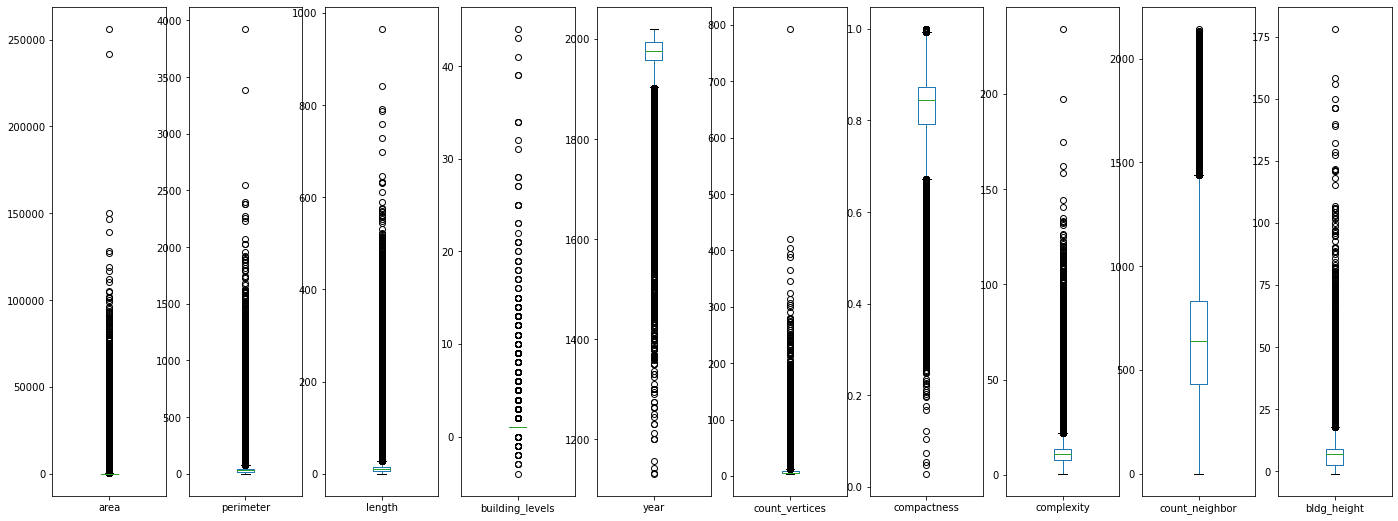

In [15]:
corr_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('feature_selection/south_holland_corr_basic_distribution.png')

In [16]:
corr = corr_df.corr()
corr

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor,bldg_height
area,1.000000,0.756569,0.744758,0.013729,0.023867,0.194515,-0.087894,0.472062,-0.110857,0.071234
perimeter,0.756569,1.000000,0.985265,0.047500,-0.019771,0.530796,-0.420994,0.903125,-0.253221,0.350724
length,0.744758,0.985265,1.000000,0.050836,-0.025168,0.481057,-0.427355,0.898550,-0.256501,0.357793
building_levels,0.013729,0.047500,0.050836,1.000000,0.003844,0.040378,-0.016426,0.053702,-0.023870,0.152110
year,0.023867,-0.019771,-0.025168,0.003844,1.000000,-0.078117,0.154674,-0.080285,-0.084828,-0.184009
count_vertices,0.194515,0.530796,0.481057,0.040378,-0.078117,1.000000,-0.522980,0.626719,-0.137103,0.347041
compactness,-0.087894,-0.420994,-0.427355,-0.016426,0.154674,-0.522980,1.000000,-0.653002,0.111732,-0.330268
complexity,0.472062,0.903125,0.898550,0.053702,-0.080285,0.626719,-0.653002,1.000000,-0.292255,0.528233
count_neighbor,-0.110857,-0.253221,-0.256501,-0.023870,-0.084828,-0.137103,0.111732,-0.292255,1.000000,-0.032116
bldg_height,0.071234,0.350724,0.357793,0.152110,-0.184009,0.347041,-0.330268,0.528233,-0.032116,1.000000


In [17]:
import seaborn as sns

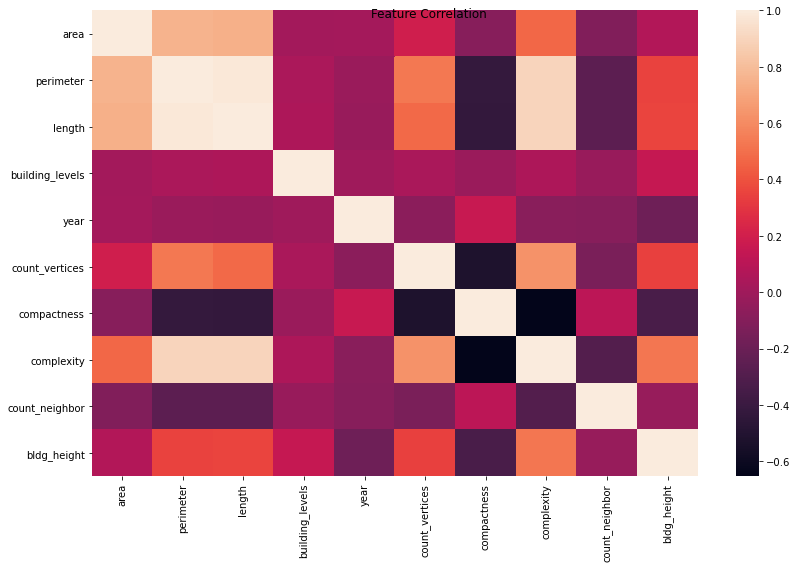

In [18]:

fig = plt.figure(figsize=(12,8))
fig.suptitle('Feature Correlation')
sns.heatmap(corr)
plt.savefig('feature_selection/south_holland_corr_heatmap.png', dpi=600)
plt.tight_layout()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [20]:
sample_df = corr_df.sample(frac=0.1, random_state=sampling_seed)
sample_df.head()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor,bldg_height
osm_way_id,,,,,,,,,,
290331826,20.723543,19.037551,7.030695,1.0,1975.0,5,0.847668,8.922675,524.0,2.64
253579997,746.393861,129.654541,52.132735,1.0,1970.0,5,0.746967,24.805370,7.0,7.33
269813980,5.825416,9.842339,3.552749,1.0,1992.0,5,0.869301,6.335291,834.0,2.66
290658087,6.949951,10.547747,3.733031,1.0,1978.0,5,0.886005,6.496273,958.0,2.59
267582911,12.405687,14.099841,4.996134,1.0,2008.0,5,0.885526,7.512924,56.0,0.18


In [21]:
X = corr_df.drop('bldg_height', axis=1)    # drop cat_cols since can't evaluate non-numeric
y = corr_df['bldg_height']

X, y

(                 area  perimeter     length  building_levels    year  \
 osm_way_id                                                             
 286229633   91.692029  42.868674  15.089279              1.0  1915.0   
 274111968   51.959050  38.097513  15.188347              1.0  1940.0   
 286582143   49.708593  36.167509  14.294876              1.0  1932.0   
 276806062   59.595171  33.119488  12.983664              1.0  1912.0   
 277091084   72.253336  38.021220  15.182823              1.0  1911.0   
 ...               ...        ...        ...              ...     ...   
 531538800    7.978339  11.417526   4.085161              1.0  2018.0   
 589028893   16.559877  16.314769   5.788602              1.0  2018.0   
 589029169   12.230199  14.641018   5.529827              1.0  2018.0   
 704960664   10.452900  12.972381   4.602133              1.0  2018.0   
 560925291    7.467665  10.975406   3.903437              1.0  2018.0   
 
             count_vertices  compactness  complex

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=train_test_seed)

In [23]:
# feature selection function
def select_features(score_function, X_train, y_train, X_test, k):
	# configure to select all features
	fs = SelectKBest(score_func=score_function, k=k)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

Feature 0 - area: 6433.409874
Feature 1 - perimeter: 181906.496658
Feature 2 - length: 191219.709543
Feature 3 - building_levels: 29832.919580
Feature 4 - year: 46042.776039
Feature 5 - count_vertices: 181265.997615
Feature 6 - compactness: 161035.570034
Feature 7 - complexity: 505998.912487
Feature 8 - count_neighbor: 1367.917051


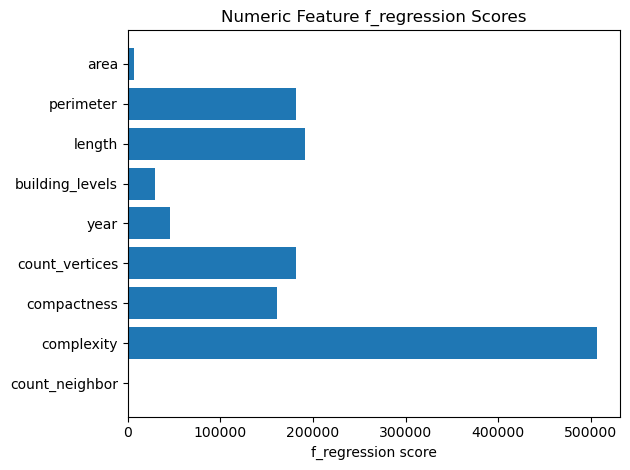

In [24]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(f_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d - %s: %f' % (i, num_cols[i], fs.scores_[i]))
# plot the scores
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(num_cols, fs.scores_)
y_pos = np.arange(len(num_cols))
ax.set_yticks(y_pos)
ax.set_yticklabels(num_cols)
ax.invert_yaxis()
ax.set_xlabel('f_regression score')
ax.set_title('Numeric Feature f_regression Scores')
plt.tight_layout()
plt.savefig('feature_selection/south_holland_corr_f_regression.png')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [25]:
sample_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor,bldg_height
count,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000
mean,126.844308,34.433210,12.489302,1.008452,1970.223709,7.308518,0.820490,11.502064,626.919606,6.199738
std,1077.427916,42.335320,14.838087,0.231465,36.657217,5.272235,0.069935,5.157643,307.590283,3.791108
min,0.102405,2.515305,1.172503,-1.000000,1262.000000,4.000000,0.073743,3.659526,0.000000,-0.070000
25%,11.027619,13.824984,5.051879,1.000000,1957.000000,5.000000,0.791938,7.568439,430.000000,2.650000
50%,50.049181,29.743907,10.844024,1.000000,1976.000000,5.000000,0.844015,11.125797,640.000000,6.700000
75%,71.365134,38.878110,14.314607,1.000000,1994.000000,8.000000,0.872037,13.335636,833.000000,8.760000
max,112001.742287,1884.831628,567.304130,34.000000,2020.000000,405.000000,0.999672,134.713458,2125.000000,149.830000


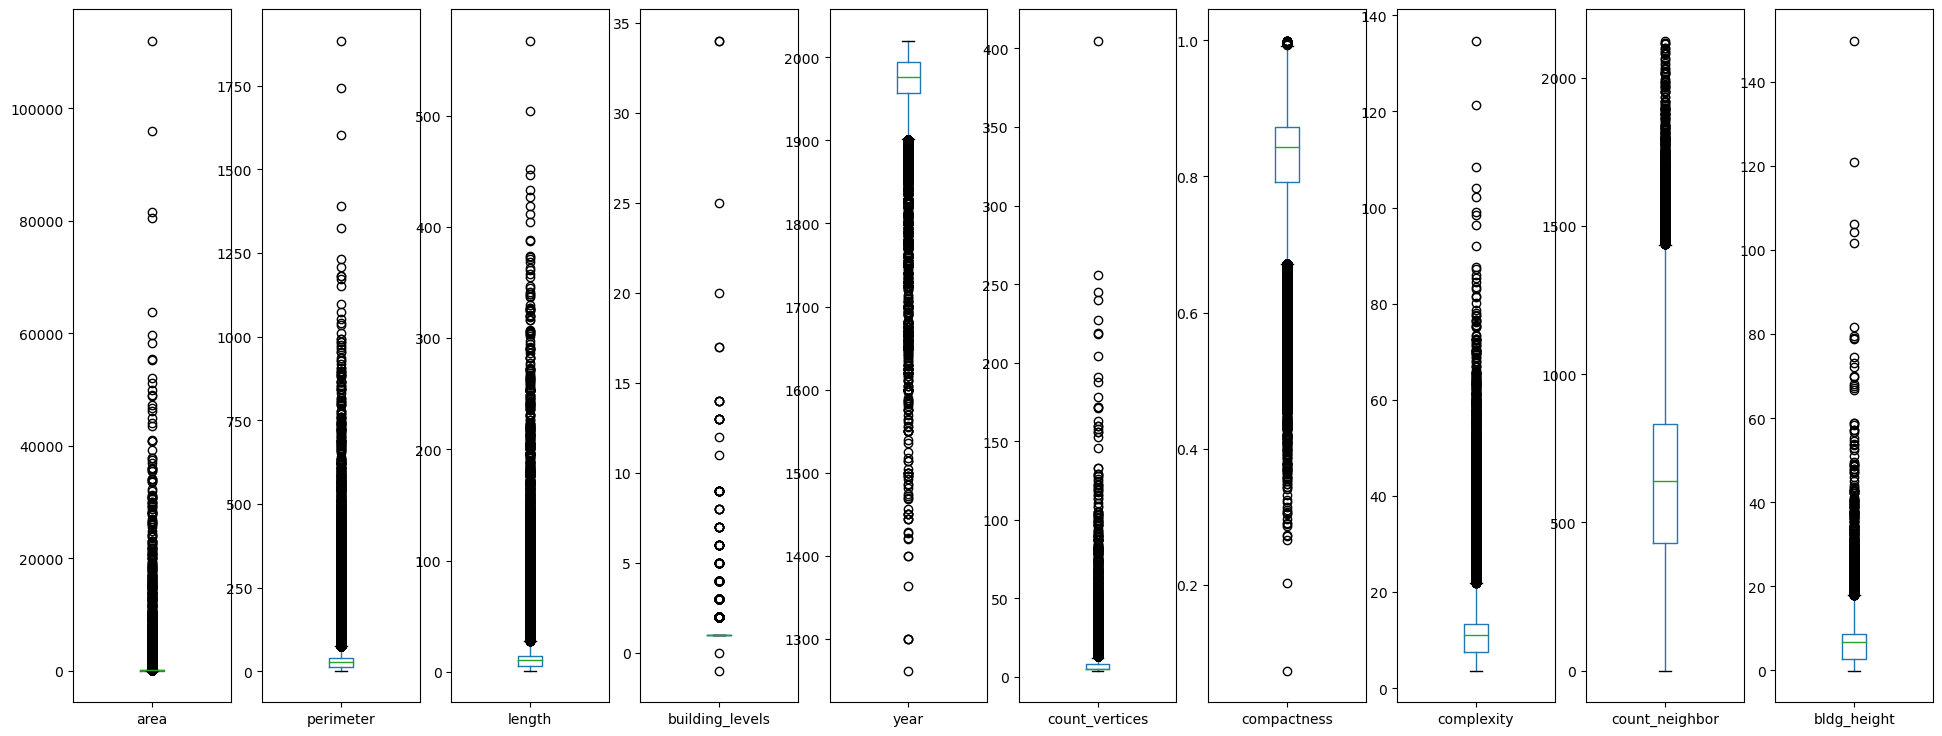

In [34]:
sample_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('feature_selection/south_holland_10prct_basic_distribution.png')
plt.savefig('exploratory_10prct/south_holland_basic_distribution.png')

In [27]:
X = sample_df.drop('bldg_height', axis=1)   # drop cat_cols since can't evaluate non-numeric
y = sample_df['bldg_height']

X, y

(                  area   perimeter     length  building_levels    year  \
 osm_way_id                                                               
 290331826    20.723543   19.037551   7.030695              1.0  1975.0   
 253579997   746.393861  129.654541  52.132735              1.0  1970.0   
 269813980     5.825416    9.842339   3.552749              1.0  1992.0   
 290658087     6.949951   10.547747   3.733031              1.0  1978.0   
 267582911    12.405687   14.099841   4.996134              1.0  2008.0   
 ...                ...         ...        ...              ...     ...   
 280636888    52.527939   30.084213  11.045477              1.0  1981.0   
 266030320     5.470624    9.414120   3.354089              1.0  2010.0   
 268444219   130.584389   72.802253  30.095593              1.0  1920.0   
 276637602    74.098478   39.696088  15.695219              1.0  1899.0   
 273975177    63.153234   33.065515  12.140212              1.0  1987.0   
 
             count_vert

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=train_test_seed)

Feature 0 - area: 813.596789
Feature 1 - perimeter: 18398.583801
Feature 2 - length: 19105.537926
Feature 3 - building_levels: 4583.079389
Feature 4 - year: 4324.452413
Feature 5 - count_vertices: 16671.452446
Feature 6 - compactness: 15546.122203
Feature 7 - complexity: 49515.522289
Feature 8 - count_neighbor: 133.716031


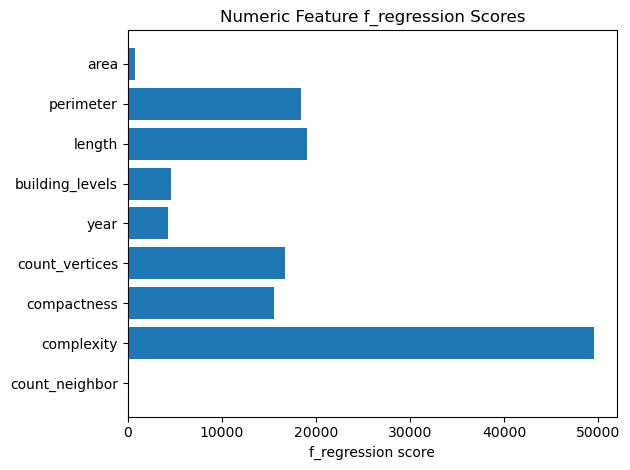

In [29]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(f_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d - %s: %f' % (i, num_cols[i], fs.scores_[i]))
# plot the scores
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(num_cols, fs.scores_)
y_pos = np.arange(len(num_cols))
ax.set_yticks(y_pos)
ax.set_yticklabels(num_cols)
ax.invert_yaxis()
ax.set_xlabel('f_regression score')
ax.set_title('Numeric Feature f_regression Scores')
plt.tight_layout()
plt.savefig('feature_selection/south_holland_10prct_corr_f_regression.png')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Feature 0 - area: 0.628447
Feature 1 - perimeter: 0.618114
Feature 2 - length: 0.618982
Feature 3 - building_levels: 0.005173
Feature 4 - year: 0.287079
Feature 5 - count_vertices: 0.169987
Feature 6 - compactness: 0.155634
Feature 7 - complexity: 0.604304
Feature 8 - count_neighbor: 0.080139


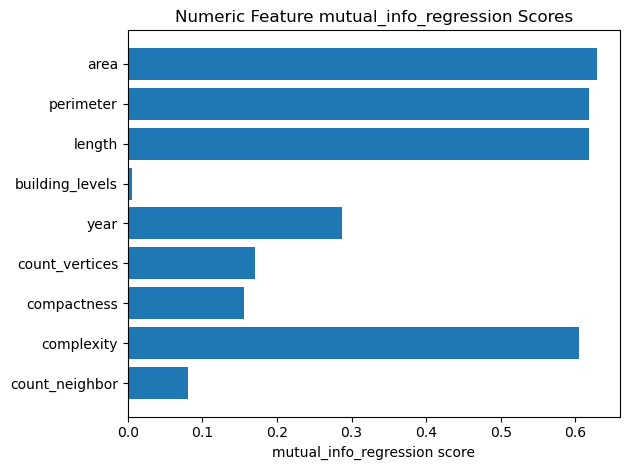

In [30]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(mutual_info_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d - %s: %f' % (i, num_cols[i], fs.scores_[i]))
# plot the scores
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(num_cols, fs.scores_)
y_pos = np.arange(len(num_cols))
ax.set_yticks(y_pos)
ax.set_yticklabels(num_cols)
ax.invert_yaxis()
ax.set_xlabel('mutual_info_regression score')
ax.set_title('Numeric Feature mutual_info_regression Scores')
plt.tight_layout()
plt.savefig('feature_selection/south_holland_10prct_mutual_information_regression.png')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
# num_df = df[num_cols].fillna(df[num_cols].mean())
# num_df.isna().sum()